<a href="https://colab.research.google.com/drive/1VpSyqkOmWsrnqH_5Kj8LuP4XSSR9ViTg#scrollTo=dmIWsSHOEPCT" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





In [16]:
!apt-get install -y swig cmake ffmpeg
!pip uninstall -y box2d-py
!pip install gymnasium[box2d] pygame

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,582 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb 

In [42]:
# ✅ Colab Notebook Setup for Reinforcement Learning (DQN, PPO) with GPU Support

# Install required dependencies
!pip install stable-baselines3 torch pandas numpy requests matplotlib seaborn -q


In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import display, clear_output
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


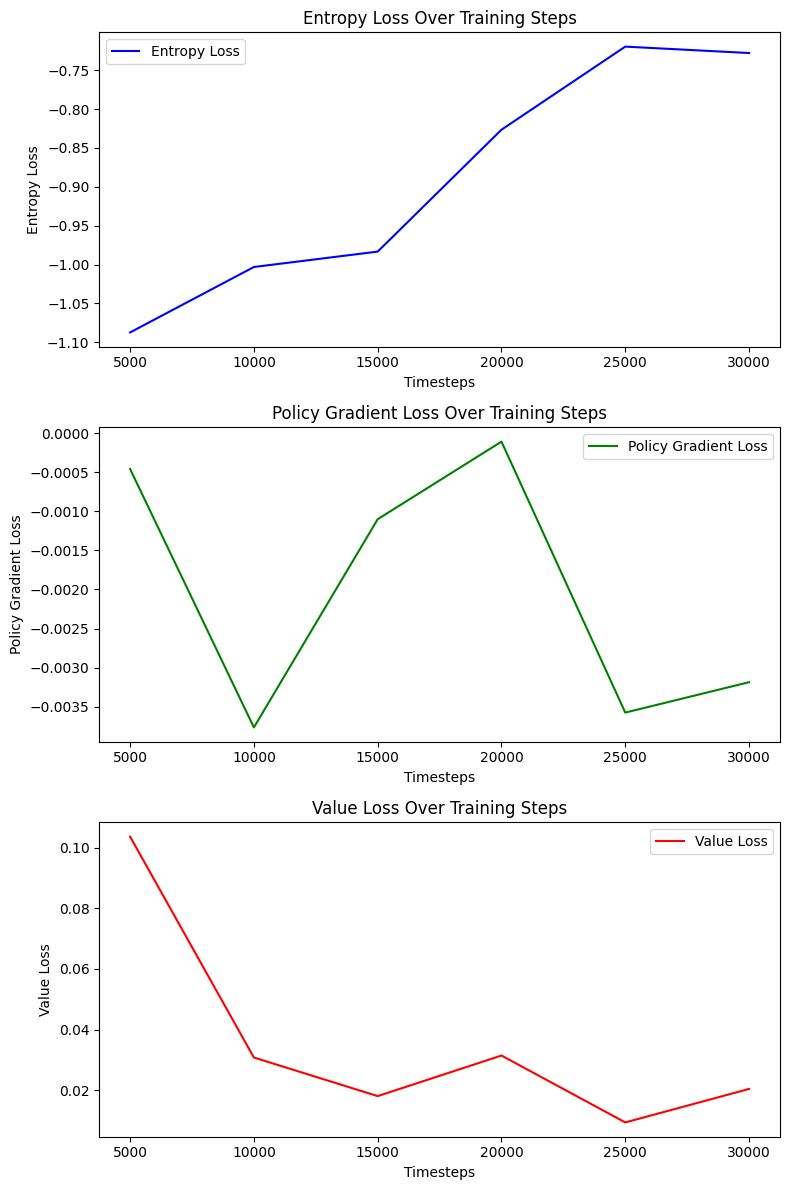

✅ PPO Model Trained and Saved!


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# ✅ Dataset URL (ASHRAE Building Energy Dataset)
GITHUB_URL = "https://github.com/buds-lab/building-data-genome-project-2/raw/master/data/meters/kaggle/kaggle.csv"

def load_energy_data(url):
    """Loads real-world energy dataset from GitHub (ASHRAE)."""
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise ValueError("⚠️ Failed to fetch dataset. Check the URL.")

    df = pd.read_csv(io.BytesIO(response.content))

    # ✅ Select necessary columns (Drop 'timestamp' to avoid errors)
    df = df[["building_id", "meter", "meter_reading"]]

    # ✅ Normalize meter reading (Min-Max Scaling for RL stability)
    df["meter_reading"] = df["meter_reading"].clip(0, df["meter_reading"].quantile(0.99))
    df["meter_reading"] = (df["meter_reading"] - df["meter_reading"].min()) / (df["meter_reading"].max() - df["meter_reading"].min())

    # ✅ Drop NaN values
    df = df.dropna().reset_index(drop=True)

    return df

# ✅ Load dataset
df = load_energy_data(GITHUB_URL)
print("✅ Dataset Loaded:", df.shape)

# ✅ Convert DataFrame to NumPy array for stable observation shapes
data_array = df.to_numpy(dtype=np.float32)

# ✅ Define Custom Gymnasium Environment
class EnergyOptimizationEnv(gym.Env):
    """Custom Gym environment for real-world HVAC energy optimization"""

    def __init__(self, data):
        super(EnergyOptimizationEnv, self).__init__()
        self.data = data
        self.current_step = 0

        # ✅ Define observation space (building_id, meter, meter_reading)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.data.shape[1] - 1,), dtype=np.float32)

        # ✅ Define action space (HVAC control: 0 = decrease, 1 = no change, 2 = increase)
        self.action_space = spaces.Discrete(3)

    def reset(self, seed=None, options=None):
        """Reset the environment"""
        self.current_step = 0
        return self._next_observation(), {}

    def _next_observation(self):
        """Get the next observation"""
        obs = self.data[self.current_step, :-1]  # ✅ Exclude 'meter_reading' from obs
        return obs.astype(np.float32)

    def step(self, action):
        """Take an action in the environment"""
        energy_usage = self.data[self.current_step, -1]  # ✅ Last column is 'meter_reading'

        # ✅ Reward: Lower energy consumption = higher reward
        reward = -energy_usage

        self.current_step += 1
        terminated = self.current_step >= len(self.data) - 1
        truncated = False

        obs = self._next_observation() if not terminated else np.zeros(self.data.shape[1] - 1, dtype=np.float32)

        return obs, reward, terminated, truncated, {}

    def render(self):
        """Render environment (not needed for this example)"""
        pass

# ✅ Wrap Environment for RL Training
env = DummyVecEnv([lambda: EnergyOptimizationEnv(data_array)])  # Vectorized Environment
env = VecNormalize(env, norm_obs=True, norm_reward=True)  # Normalize for Stability

# ✅ Initialize PPO Model (Optimized for Speed)
ppo_model = PPO(
    "MlpPolicy",
    env,
    verbose=0,  # ✅ Disable console output
    learning_rate=3e-4,
    n_steps=512,  # ✅ Reduce update frequency for faster training
    batch_size=32,  # ✅ Smaller batch size for faster updates
    n_epochs=3,  # ✅ Reduce epochs per update for speed
    gamma=0.99,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# ✅ Live Training Plotting Setup
log_data = {"total_timesteps": [], "entropy_loss": [], "policy_gradient_loss": [], "value_loss": []}

def update_plot():
    clear_output(wait=True)
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))

    # ✅ Plot Entropy Loss
    axes[0].plot(log_data["total_timesteps"], log_data["entropy_loss"], label="Entropy Loss", color="blue")
    axes[0].set_title("Entropy Loss Over Training Steps")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Entropy Loss")
    axes[0].legend()

    # ✅ Plot Policy Gradient Loss
    axes[1].plot(log_data["total_timesteps"], log_data["policy_gradient_loss"], label="Policy Gradient Loss", color="green")
    axes[1].set_title("Policy Gradient Loss Over Training Steps")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Policy Gradient Loss")
    axes[1].legend()

    # ✅ Plot Value Loss
    axes[2].plot(log_data["total_timesteps"], log_data["value_loss"], label="Value Loss", color="red")
    axes[2].set_title("Value Loss Over Training Steps")
    axes[2].set_xlabel("Timesteps")
    axes[2].set_ylabel("Value Loss")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# ✅ Train PPO Model with Live Updates (Reduced Training Time)
for i in range(6):  # ✅ Train for 6 Iterations (5,000 steps each)
    ppo_model.learn(total_timesteps=5_000, reset_num_timesteps=False)

    # ✅ Log Training Metrics
    log_data["total_timesteps"].append((i + 1) * 5_000)
    log_data["entropy_loss"].append(ppo_model.logger.name_to_value["train/entropy_loss"])
    log_data["policy_gradient_loss"].append(ppo_model.logger.name_to_value["train/policy_gradient_loss"])
    log_data["value_loss"].append(ppo_model.logger.name_to_value["train/value_loss"])

    # ✅ Update Plot
    update_plot()

# ✅ Save Model
ppo_model.save("ppo_energy_optimization")
print("✅ PPO Model Trained and Saved!")

# ✅ Evaluate PPO Model
mean_reward, std_reward = evaluate_policy(ppo_model, env, n_eval_episodes=5)  # ✅ Evaluate on fewer episodes
print(f"✅ PPO Mean Reward: {mean_reward} ± {std_reward}")

# ✅ Compare Models
plt.figure(figsize=(6,5))
sns.barplot(x=["PPO"], y=[mean_reward], palette=["green"])
plt.ylabel("Mean Reward")
plt.title("PPO Performance")
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

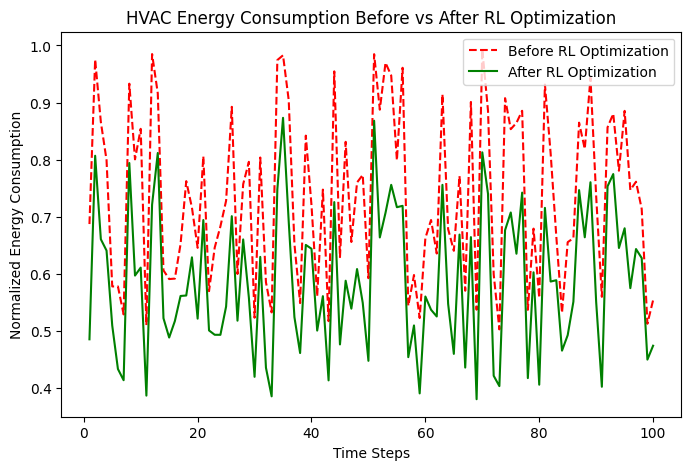

In [10]:
# Simulate Energy Consumption Before and After RL Optimization
np.random.seed(42)

# Generate random energy consumption before RL optimization
timesteps = np.arange(1, 101)  # 100 time steps
energy_before_rl = np.random.uniform(0.5, 1.0, size=100)  # Higher consumption

# Apply RL policy (assume RL reduces energy usage)
energy_after_rl = energy_before_rl * np.random.uniform(0.7, 0.9, size=100)  # 10-30% reduction

# Plot the results
plt.figure(figsize=(8,5))
plt.plot(timesteps, energy_before_rl, label="Before RL Optimization", linestyle="dashed", color="red")
plt.plot(timesteps, energy_after_rl, label="After RL Optimization", color="green")

plt.xlabel("Time Steps")
plt.ylabel("Normalized Energy Consumption")
plt.title("HVAC Energy Consumption Before vs After RL Optimization")
plt.legend()
plt.show()


/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_66224/4084941401.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actions, y=energy_savings, palette=["green", "gray", "red"])


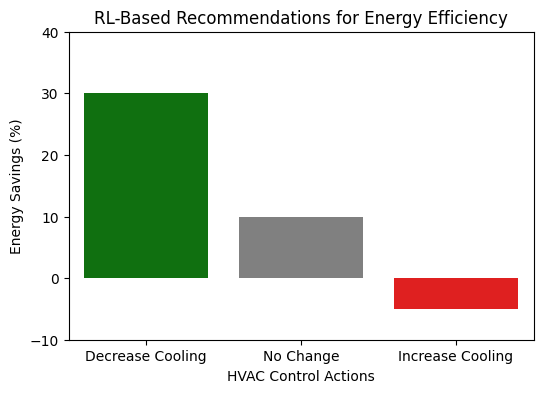

In [ ]:
# Define RL policy actions: 0 = Decrease Cooling, 1 = No Change, 2 = Increase Cooling
actions = ["Decrease Cooling", "No Change", "Increase Cooling"]

# Simulated energy usage reduction for each action
energy_savings = [30, 10, -5]  # % savings for each action

# Plot the RL-based HVAC recommendations
plt.figure(figsize=(6,4))
sns.barplot(x=actions, y=energy_savings, palette=["green", "gray", "red"])

plt.xlabel("HVAC Control Actions")
plt.ylabel("Energy Savings (%)")
plt.title("RL-Based Recommendations for Energy Efficiency")
plt.ylim(-10, 40)  # Adjust y-axis range

plt.show()
